### Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación

### Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones 2022
Búsqueda y Recomendación para Textos Legales

Mentor: Jorge E. Pérez Villella

# Práctico Análisis y Curación de Datos

Integrantes:
* Fernando Agustin Cardellino
* Adrian Zelaya

### Objetivos:

Normalizar el corpus generado en el práctico anterior, teniendo en cuenta los siguientes aspectos:

* tokenización, 
* pasar a minúsculas, 
* separar puntuación, 
* stemming y lematización, 
* eliminar stopwords (o no), 
* eliminar las palabras con frecuencia menor a n. 

Analizar las palabras más frecuentes de todo el corpus, por fuero y de 5 documentos. Compararlo con el resultado obtenido en el ejercicio anterior. Se observa algún cambio significativo?

Hacer una explicación con ejemplos tomando algunas palabras al azar entre lo que es stemming y lemmatizing para entender que nos da cada uno de estos procesos y cual es conveniente utilizar en cada caso.

Opcional:

* Investigar que es Segmentación y compararlo con Tokenización. Ejemplificar con un documento.
* Investigar NER (Named Entity Recognition - Reconocimiento de Entitades Nombradas). Buscar las Entidadas Nombradas mas frecuentes en todo el corpus y por fuero. 


Fecha de Entrega: 17 de junio de 2022

In [27]:
# Importamos las librerías necesarias

import numpy as np
import pandas as pd
import os
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.stem import porter, snowball
#import nltk
#nltk.download('stopwords')  # Descomentar para bajar las stopwords

In [28]:
# Cargamos modelo de spacy y stopwords de NLTK
nlp = spacy.load("es_core_news_lg")

CURR_DIR = os.getcwd()  # Gets current directory
STOPWORDS_ES = stopwords.words('spanish')
BREAKPOINT=None  # None para analizar todos los documentos, sino un número para analizar hasta n documentos
MAX_WORDS=1000
IMG_NAME = "legal-icon-png"


### Funciones que vamos a utilizar en el Práctico

##### Funciones auxiliares

In [29]:
def getListOfFiles(dirName, return_dir=False):
    # create a list of file and sub directories
    # names in the given directory
    files = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for file in files:
        # Create full path
        fullPath = os.path.join(dirName, file)
        # If entry is a directory then get the list of files in this directory
        if os.path.isdir(fullPath):
            if return_dir:
                allFiles.append(fullPath.split(os.sep)[-1])
            else:
                allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)

    return allFiles


def save_to_pickle(obj, filename):
    """
    TODO: [E111] Pickling a token is not supported, because tokens are only views of the parent Doc and can't exist on
    their own. A pickled token would always have to include its Doc and Vocab, which has practically no advantage over
    pickling the parent Doc directly. So instead of pickling the token, pickle the Doc it belongs to.
    :param obj:
    :param filename:
    :return:
    """

    file_path = os.path.join(CURR_DIR, filename)
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, 'rb') as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)


def series_to_dataframe(series, column_names=None):
    col_names = [series.name, 'values'] if column_names is None else column_names
    return pd.DataFrame([series.index, series.values], columns=col_names)


##### Funciones específicas del análisis

In [30]:
def get_tokens(files_path, fuero_name=None, breakpoint=None, object_type=None):
    """
    Función que arma el corpus de palabras y las tokeniza, utilizando SpaCy.
    Si `breakpoint` != None, dar el número de docs con el que se interrumpe la función
    object_type: indica el tipo de objeto que devuelve, i.e. 'token'/None (SpaCy object `token`), 'word' (texto/string) 
    or 'entity' (SpaCy object `entity`) 
    """
    def get_conditions(token, case):
        if case == 'entity':
            return True
        else:
            return token.is_alpha and not token.is_stop
    
    corpus = {}

    tokens = []

    i = 0
    for filename in getListOfFiles(files_path):
        file_name = filename.split(os.sep)[-1]
        fuero = fuero_name if fuero_name is not None else filename.split(os.sep)[-2]
        if fuero not in corpus.keys():
            corpus[fuero] = {}

        with open(filename, encoding='utf-8') as file:
            file_text = file.read()
            # Tokenizamos el corpus
            nlp_doc = nlp(file_text)
            corpus[fuero][file_name] = nlp_doc
            
            iterable = nlp_doc.ents if object_type == 'entity' else nlp_doc
            
            for token in iterable:
                if get_conditions(token, case=object_type):
                    tokens.append(# lematizamos y pasamos a minúscula (en modo 'palabras'/'word' solamente)
                        token.lemma_.lower() if object_type == 'word' else token
                    )
                    
        # remover esta sección (testing)
        if breakpoint:
            i += 1
            if i > breakpoint:
                break
    return tokens, corpus 


def get_lemmas_stem_from_tokens(tokens, stemmer, language='spanish'):
    aux_dict = {
        'word': [token.lower_ for token in tokens],
        'lemma': [token.lemma_.lower() for token in tokens],
        'stem': [stemmer.stem(token.lower_) for token in tokens]
    }
    return pd.DataFrame(aux_dict)
    
    
def get_ner_from_tokens(tokens):
    aux_dict = {
        'token': [token.text for token in tokens],
        'entity': [token.ent_type_ for token in tokens]
    }
    return pd.DataFrame(aux_dict)
    

def get_conteo_palabras(palabras):
    """Función que genera un pandas DataFrame con la frecuencia de las palabras
    """
    palabras_df = pd.DataFrame([{'palabra': str(x).lower()} for x in palabras])
    # print(corpus_df.head())

    return palabras_df.groupby(['palabra'])['palabra'].count().sort_values(ascending=False)

    
def comparar_frecuencias_palabras(dataframe, max_palabras=50 ,description=None):
    """Función que compara entre las palabras más y menos frecuentes 
    """
    if description:
        print(description)
    print(
        f"\nLas {max_palabras} palabras más frecuentes son:\n{dataframe.head(max_palabras)}"
    )# La mayoría son todas stopwords, a partir de la 20ma empiezan a haber palabras propias del ámbito jurídico
    
    print(f"\nLas {max_palabras} palabras menos frecuentes son:\n{dataframe.tail(max_palabras)}"
    )  # palabras normales pero donde la mayoría comparte una base en común (e.g. ordenadas, ordenado, ordenando) >> con lematización, se podría disminuir esto
    
    return dataframe.head(max_palabras).index.values


def plot_histogram(dataframe, threshold=1, y_low=None, description=None):

    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    plt.figure(figsize=(20, 8), dpi=80)
    
    limit = threshold if threshold else len(dataframe)
    
    x=dataframe[:limit].index 
    y=dataframe[:limit].values
    
    y_cutoff = dataframe[:threshold].quantile(0.8) if y_low is None else y_low
    
    my_color = np.where(y>=y_cutoff, 'orange', 'skyblue')
    
    # The vertical plot is made using the vline function
    plt.vlines(x=x, ymin=0, ymax=y, color=my_color, alpha=0.4, linewidth=3.5)
    plt.scatter(x, y, color=my_color, s=25, alpha=1)

    # Add title and axis names
    identifier = '' if description is None else f" ({description})"
    
    plt.title(f"Distribución de Frecuencia de Palabras{identifier}", loc='center')
    plt.xlabel('Palabra')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation = 45)
    
    # Formateamos los valores del eje-y
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

    # Show the graph
    plt.show()
    
def show_zipf(dataframe, description=None):
    """Función que grafica la Ley de Zipf (scatterplot con ejes en escala logarítmica)
    """
    sns.set(style="darkgrid")
    
    rank_palabras = [x + 1 for x in range(len(dataframe))]
    
    sns.scatterplot(x=rank_palabras,
                    y=dataframe).set(xscale="log",
                                     yscale="log",
                                     ylabel='log(Frecuencia)',
                                     xlabel='log(Orden)')
    
    identifier = '' if description is None else f" ({description})"
    plt.title(f"Ley de Zipf{identifier}", loc='center')
    
    plt.show()
    

def generar_wordcloud(img_name, stopwords, tokens, output_path, max_words=MAX_WORDS):
    """Función que genera una nube de palabras (wordcloud) sobre una imagen de fondo.    
    """
    
    image_name = os.path.join("img", f"{img_name}.jpg")

    
    # Generate a word cloud image
    mask = np.array(Image.open(image_name))
    text = ' '.join(tokens)
    wordcloud_law = WordCloud(
        stopwords=stopwords,
        background_color="white", 
        mode="RGBA",
        max_words=max_words,
        mask=mask).generate(text)
    
    # create coloring from image
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[7, 7])
    plt.imshow(wordcloud_law.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    
    # store to file
    plt.savefig(output_path, format="png")
    
    plt.show()
    

def generar_corpus(file_path, breakpoint, fuero_name=None, verbose=True, object_type='word'):
    if verbose:
        print("Generamos Corpus de palabras y conteo de frecuencias")
    
    # Generamos el corpus de palabras, y el diccionario con el mapeo de los fueros con sus respectivos documentos
    palabras, corpus_dic = get_tokens(file_path, fuero_name=fuero_name, breakpoint=breakpoint, object_type='word')

    frecuencia_palabras_df = get_conteo_palabras(palabras)
    
    if verbose:
        print(f"Algunas palabras: {palabras[:5]}")
    
    return frecuencia_palabras_df, palabras

    
def comparar_stemming_lematization(file_path, breakpoint):
    print("\nStemming vs Lematization")
    
    # Snowball stemmer is a slightly improved version of the Porter stemmer and is usually preferred over the latter. (https://stackabuse.com/python-for-nlp-tokenization-stemming-and-lemmatization-with-spacy-library/)
    # Also Snowball supports Spanish
    stemmer = snowball.SnowballStemmer(language='spanish')

    tokens, _ =  get_tokens(file_path, breakpoint=breakpoint)

    palabras_df = get_lemmas_stem_from_tokens(tokens, stemmer=stemmer)

    print(palabras_df)

### Normalización del corpus
Normalizar el corpus generado en el práctico anterior, teniendo en cuenta los siguientes aspectos:
- tokenización,
- pasar a minúsculas,
- separar puntuación,
- stemming y lematización,
- eliminar stopwords (o no),
- eliminar las palabras con frecuencia menor a n.

Analizar las palabras más frecuentes de todo el corpus, por fuero y de 5 documentos. Compararlo con el resultado obtenido en el ejercicio anterior. Se observa algún cambio significativo?

Hacer una explicación con ejemplos tomando algunas palabras al azar entre lo que es stemming y lemmatizing para entender que nos da cada uno de estos procesos y cual es conveniente utilizar en cada caso.

In [31]:
# Ubicación de los documentos
filesDir = os.path.join(CURR_DIR, "Documentos")

# Obtenemos lista de los fueros
fueros = getListOfFiles(filesDir, return_dir=True)

### Análisis de 5 documentos y todo el corpus


Análisis para 5 documentos

Generamos Corpus de palabras y conteo de frecuencias
Algunas palabras: ['sala', 'laboral', 'tribunal', 'superior', 'protocolo']

Stemming vs Lematization
            word       lemma       stem
0           sala        sala        sal
1        laboral     laboral    laboral
2       tribunal    tribunal   tribunal
3       superior    superior   superior
4      protocolo   protocolo   protocol
...          ...         ...        ...
4915     eduardo     eduardo     eduard
4916      javier      javier       javi
4917       fecha       fecha       fech
4918  expediente  expediente  expedient
4919         nro         nro        nro

[4920 rows x 3 columns]

Ánalisis visual



/run/user/1000/app/com.jetbrains.PyCharm-Community/ipykernel_456/1811313543.py:116: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


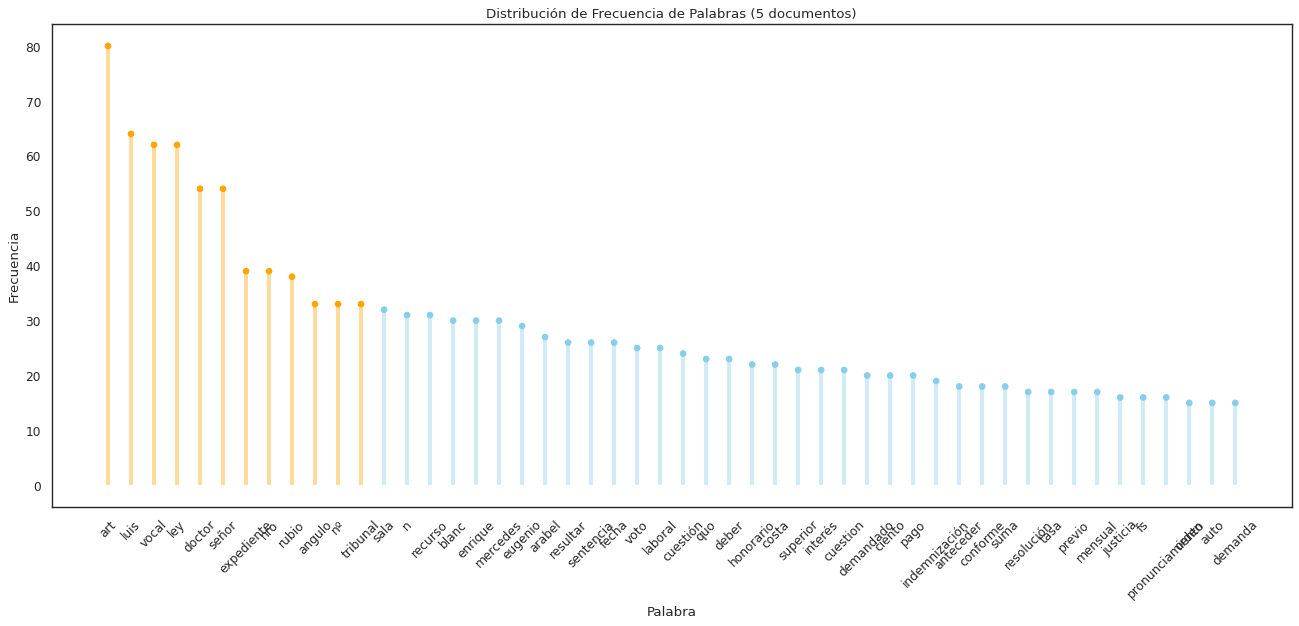

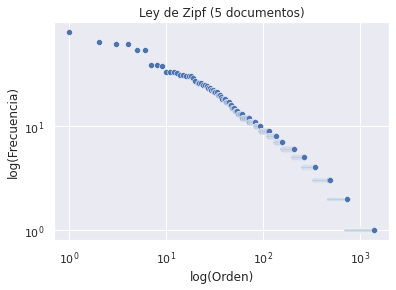


Word cloud (5 docs)



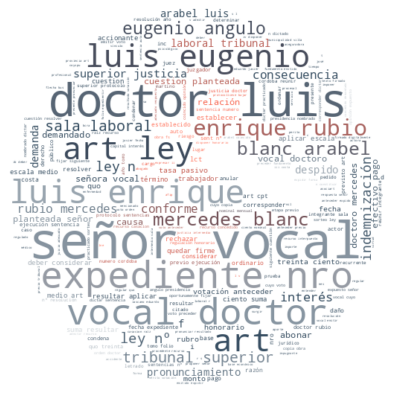


Word cloud de 50 palabras más frecuentes (5 docs)



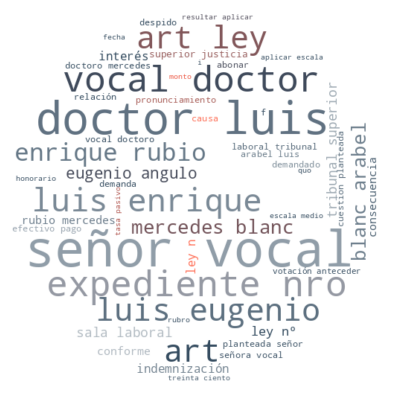


Análisis para todos documentos

Generamos Corpus de palabras y conteo de frecuencias
Algunas palabras: ['sala', 'laboral', 'tribunal', 'superior', 'protocolo']

Stemming vs Lematization
              word       lemma      stem
0             sala        sala       sal
1          laboral     laboral   laboral
2         tribunal    tribunal  tribunal
3         superior    superior  superior
4        protocolo   protocolo  protocol
...            ...         ...       ...
524798   argentina   argentina  argentin
524799  actualidad  actualidad    actual
524800        flug        flug      flug
524801        data        data       dat
524802      fiscal      fiscal    fiscal

[524803 rows x 3 columns]

Ánalisis visual



/run/user/1000/app/com.jetbrains.PyCharm-Community/ipykernel_456/1811313543.py:116: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


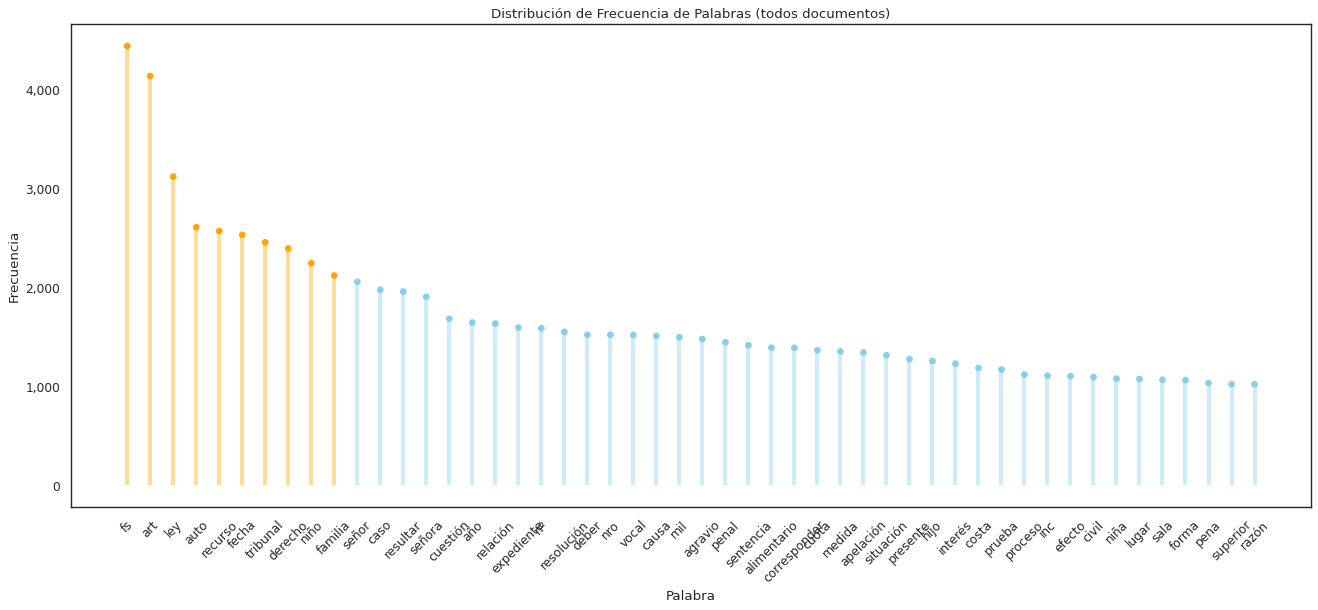

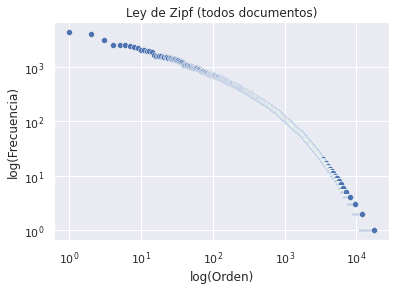


Word cloud (todos docs)



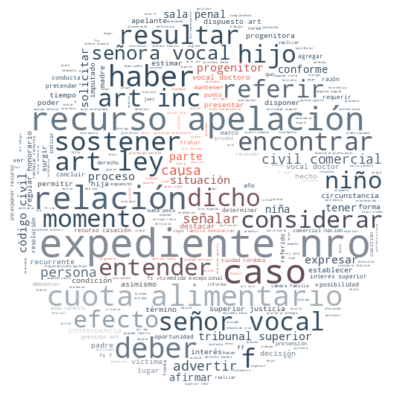


Word cloud de 50 palabras más frecuentes (todos docs)



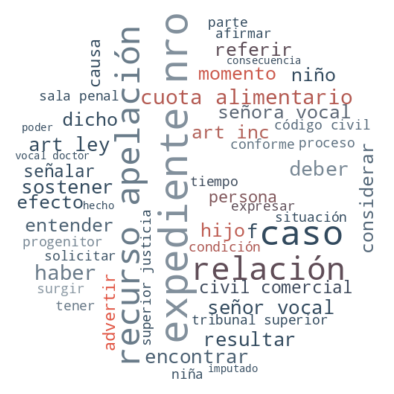

In [32]:
breakpoints = [5, BREAKPOINT] # BREAKPOINT indica hasta cuantos documentos se van a tomar en el análisis (default=5)

for breakpoint in breakpoints:
    
    n_docs = breakpoint if breakpoint else 'todos'
    
    print(f"\nAnálisis para {n_docs} documentos\n")
    
    frecuencia_palabras_df, palabras = generar_corpus(filesDir, breakpoint)
    
    comparar_stemming_lematization(filesDir, breakpoint)
    
    print("\nÁnalisis visual\n")
    
    identifier = f"{n_docs} documentos"
    plot_histogram(
        frecuencia_palabras_df,
        threshold=50,  # Nos quedamos con las 50 palabras más frecuentes (por legibilidad)
        y_low=None,
        description=identifier)
    
    show_zipf(frecuencia_palabras_df, description=identifier)
    
    print(f"\nWord cloud ({n_docs} docs)\n")
    output_name = os.path.join("img", f"{IMG_NAME}_wordcloud_practico_2_{n_docs}.png")

    generar_wordcloud(IMG_NAME, STOPWORDS_ES, palabras, output_name)
    
    # n más frecuente
    n = 50
    output_name = os.path.join("img", f"{IMG_NAME}_wordcloud_practico_2_n{n}.png")
    
    print(f"\nWord cloud de {n} palabras más frecuentes ({n_docs} docs)\n")

    generar_wordcloud(IMG_NAME, STOPWORDS_ES, palabras, output_name, max_words=n)
    
    

### Análisis por fueros



Stemming vs Lematization
              word       lemma     stem
0           cámara      cámara      cam
1          familia     familia   famili
2       nominación  nominación    nomin
3          córdoba     córdoba   cordob
4       resolución  resolución   resolu
...            ...         ...      ...
240100       bajen       bajar      baj
240101   presentes    presente  present
240102     juzgado     juzgado     juzg
240103      origen      origen     orig
240104     efectos      efecto    efect

[240105 rows x 3 columns]
Ánalisis visual



/run/user/1000/app/com.jetbrains.PyCharm-Community/ipykernel_456/1811313543.py:116: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


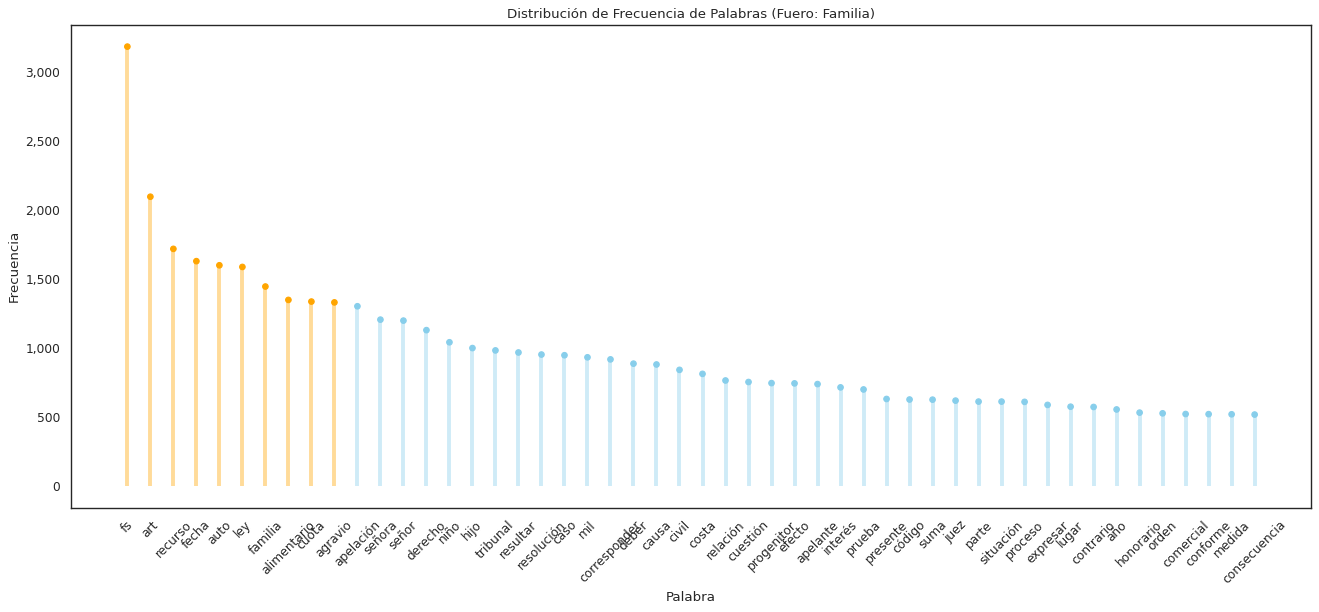

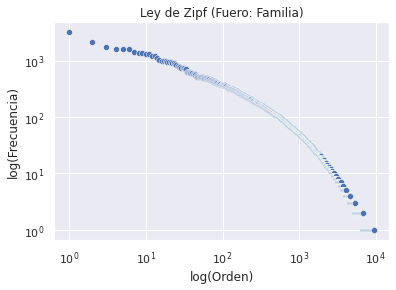


Word cloud (Fuero: Familia)



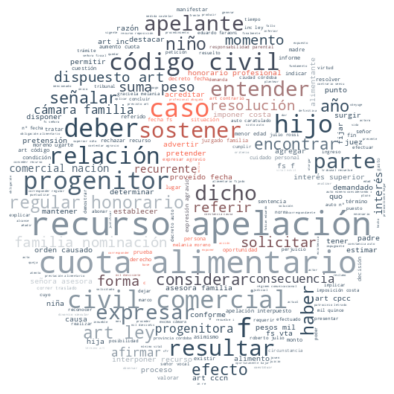


Word cloud de 50 palabras más frecuentes (Fuero: Familia)



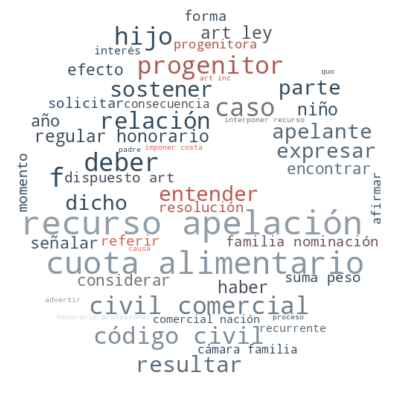


Stemming vs Lematization
             word       lemma       stem
0            sala        sala        sal
1         laboral     laboral    laboral
2        tribunal    tribunal   tribunal
3        superior    superior   superior
4       protocolo   protocolo   protocol
...           ...         ...        ...
30282     eduardo     eduardo     eduard
30283      javier      javier       javi
30284       fecha       fecha       fech
30285  expediente  expediente  expedient
30286         nro         nro        nro

[30287 rows x 3 columns]
Ánalisis visual



/run/user/1000/app/com.jetbrains.PyCharm-Community/ipykernel_456/1811313543.py:116: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


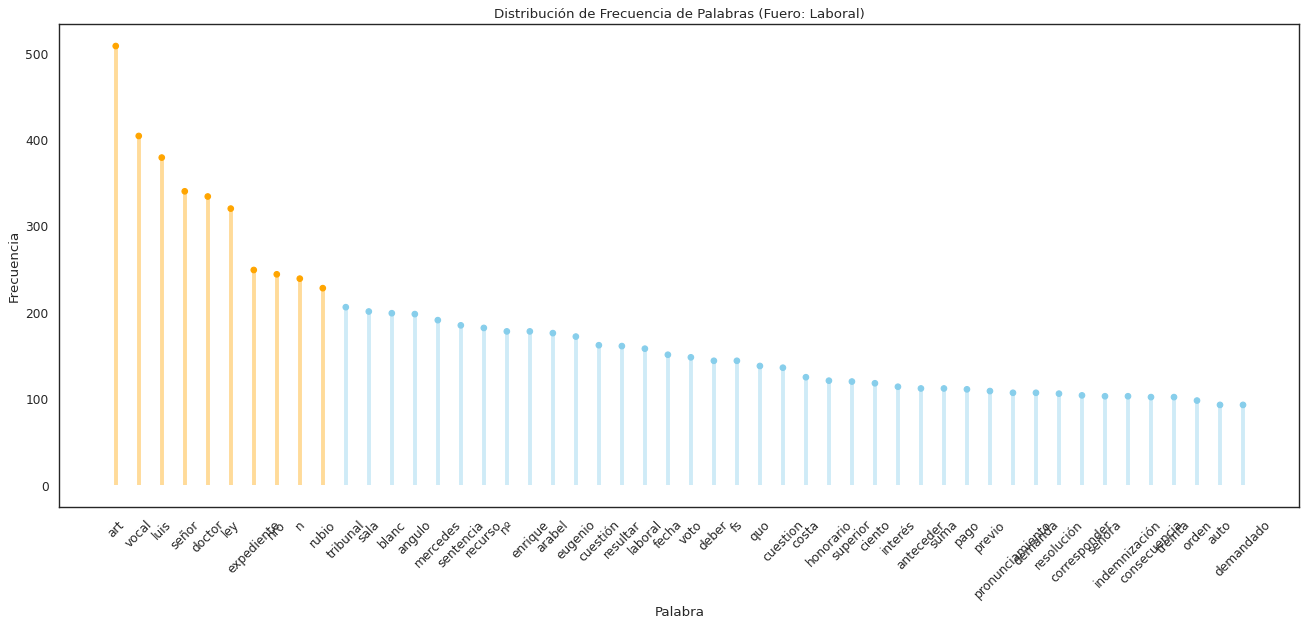

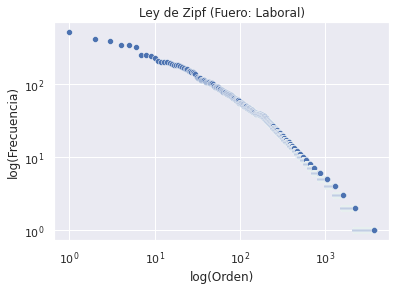


Word cloud (Fuero: Laboral)



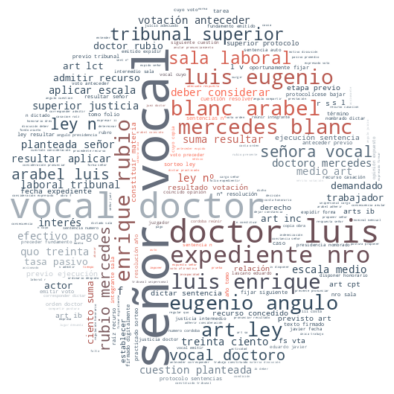


Word cloud de 50 palabras más frecuentes (Fuero: Laboral)



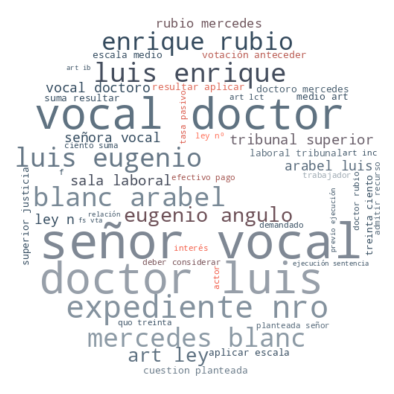


Stemming vs Lematization
              word        lemma       stem
0            datos         dato        dat
1            causa        causa       caus
2             sede         sede        sed
3          córdoba      córdoba     cordob
4      dependencia  dependencia  dependent
...            ...          ...        ...
77116    argentina    argentina   argentin
77117   actualidad   actualidad     actual
77118         flug         flug       flug
77119         data         data        dat
77120       fiscal       fiscal     fiscal

[77121 rows x 3 columns]
Ánalisis visual



/run/user/1000/app/com.jetbrains.PyCharm-Community/ipykernel_456/1811313543.py:116: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


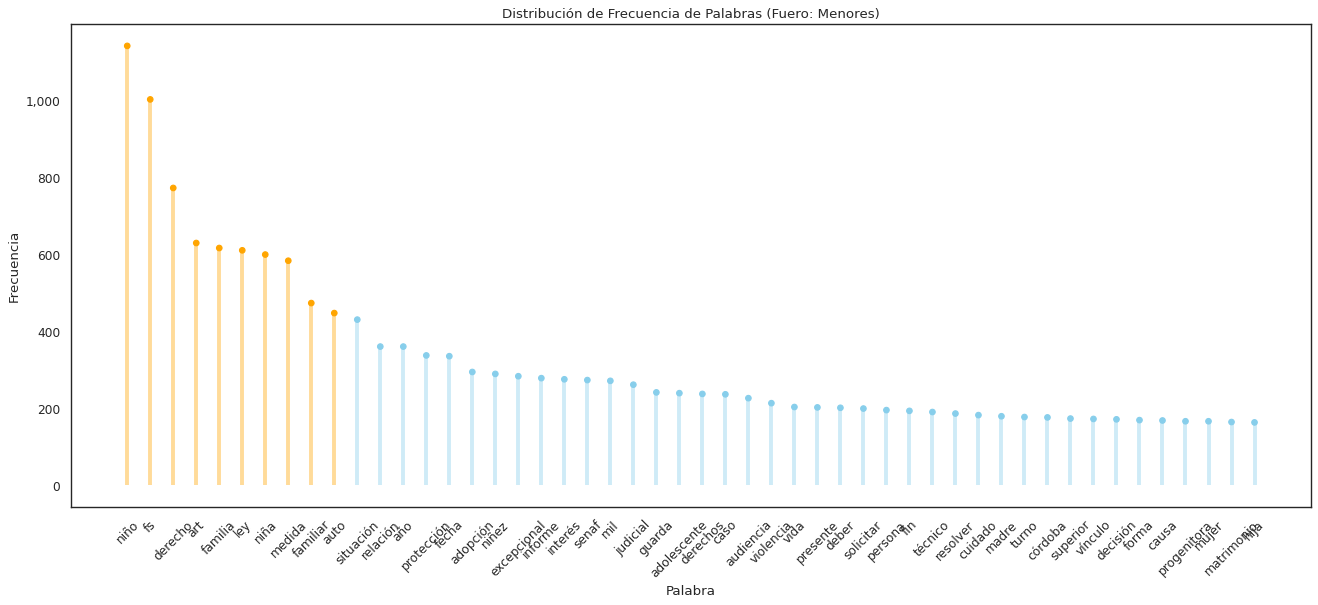

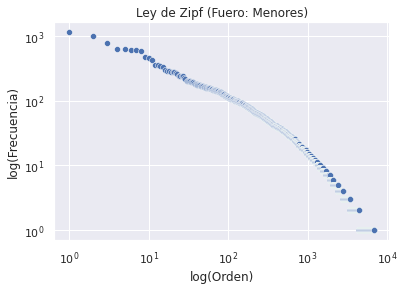


Word cloud (Fuero: Menores)



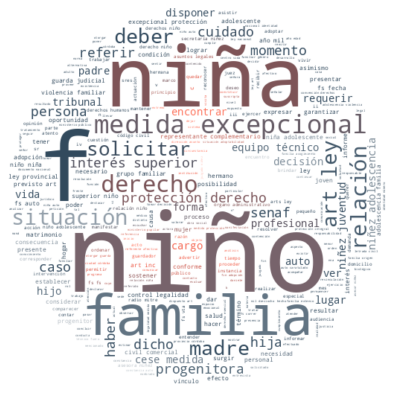


Word cloud de 50 palabras más frecuentes (Fuero: Menores)



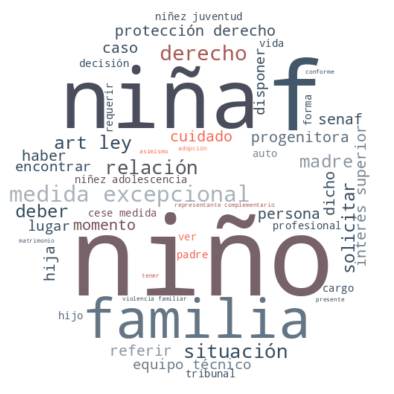


Stemming vs Lematization
              word       lemma       stem
0             sala        sala        sal
1            penal       penal      penal
2         tribunal    tribunal   tribunal
3         superior    superior   superior
4        protocolo   protocolo   protocol
...            ...         ...        ...
177285       maría       maría        mar
177286  secretario  secretario  secretari
177287     general     general    general
177288  expediente  expediente  expedient
177289         nro         nro        nro

[177290 rows x 3 columns]
Ánalisis visual



/run/user/1000/app/com.jetbrains.PyCharm-Community/ipykernel_456/1811313543.py:116: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


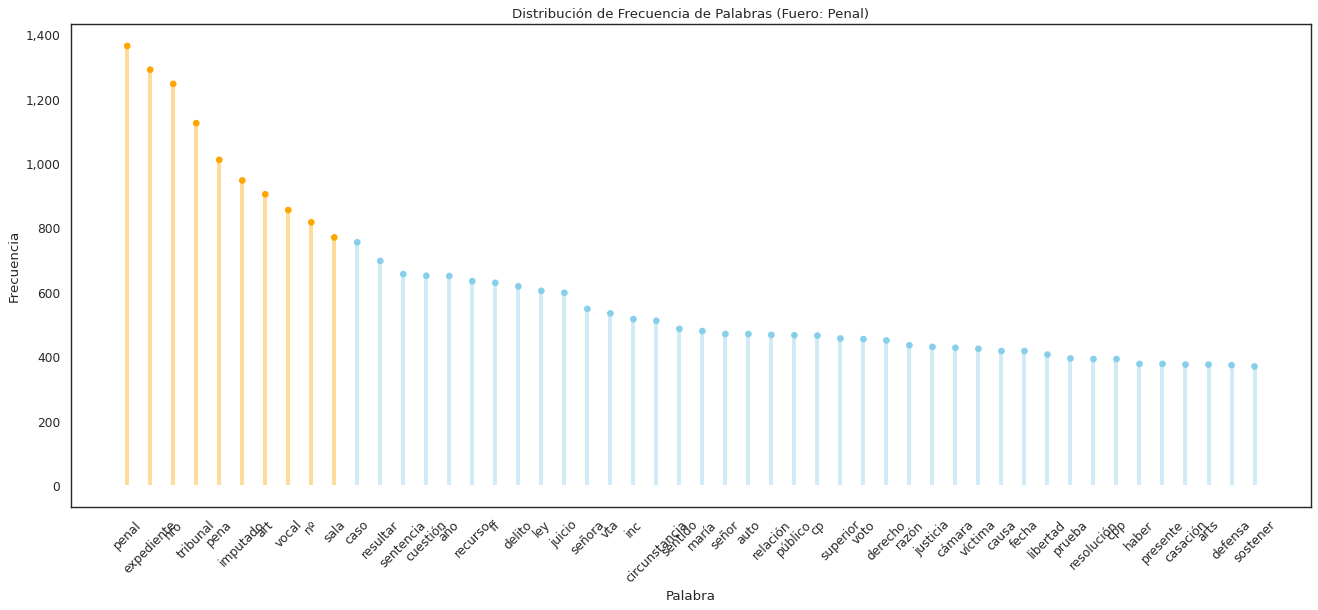

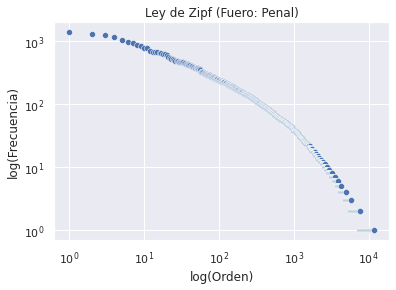


Word cloud (Fuero: Penal)



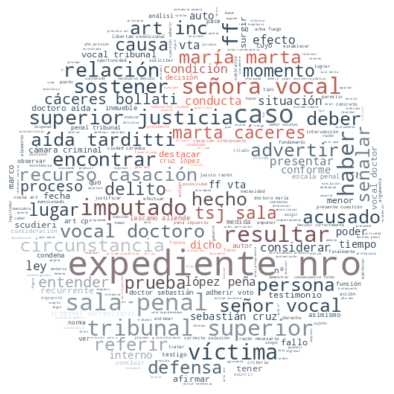


Word cloud de 50 palabras más frecuentes (Fuero: Penal)



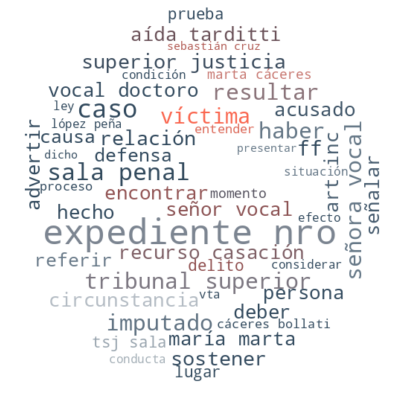

In [33]:
# Analizamos por fueros

fueros_lista = []

for fuero in ['FAMILIA', 'LABORAL', 'MENORES', 'PENAL']:
    filesDir = os.path.join(CURR_DIR, "Documentos", fuero)
    identifier = f"Fuero: {fuero.title()}"
    
    frecuencia_palabras_df, palabras = generar_corpus(filesDir, fuero_name=fuero, breakpoint=BREAKPOINT, verbose=False)
    
    comparar_stemming_lematization(filesDir, BREAKPOINT)
    
    print("Ánalisis visual\n")
    
    plot_histogram(
        frecuencia_palabras_df,
        threshold=50,  # Nos quedamos con las 50 palabras más frecuentes (por legibilidad)
        y_low=None,
        description=identifier)
    
    show_zipf(frecuencia_palabras_df, description=identifier)
    
    print(f"\nWord cloud ({identifier})\n")
    
    output_name = os.path.join("img", f"{IMG_NAME}_wordcloud_practico_2_{fuero}.png")

    generar_wordcloud(IMG_NAME, STOPWORDS_ES, palabras, output_name)
    
    # n más frecuente
    n = 50
    output_name = os.path.join("img", f"{IMG_NAME}_wordcloud_practico_2_n{n}.png")
    
    print(f"\nWord cloud de {n} palabras más frecuentes ({identifier})\n")

    generar_wordcloud(IMG_NAME, STOPWORDS_ES, palabras, output_name, max_words=n)

## Opcionales

Investigar que es Segmentación y compararlo con Tokenización. Ejemplificar con un documento.
Investigar NER (Named Entity Recognition - Reconocimiento de Entitades Nombradas). Buscar las Entidadas Nombradas mas frecuentes en todo el corpus y por fuero.

### Segmentación vs Tokenización

https://tm-town-nlp-resources.s3.amazonaws.com/ch2.pdf

Segmentación es más abstracto >> es dividir el texto en partes: oraciones, párrafos, palabras, etc.

Tokenización es un caso específico de segmentación >> es la mínima unidad en la que podemos dividir el texto, e.g. palabras, puntuaciones, etc.


In [34]:
doc_path = os.path.join(CURR_DIR, "Documentos", "FAMILIA", "A., A.-C.E.Divorcio vincular.doc.txt")

In [35]:
with open(doc_path, encoding='utf-8') as file:
    file_text = file.read()
    nlp_doc = nlp(file_text)
    i=0
    print("Ejemplo de tokenización vs segmentación por oración.\n")
    for token in nlp_doc:
        print(f"token: {token.text} - sentence: {token.sent}\n")
        i+=1
        if i > 5:
            break

Ejemplo de tokenización vs segmentación por oración.

token: AUTO - sentence: AUTO n.º 3.

token: n.º - sentence: AUTO n.º 3.

token: 3 - sentence: AUTO n.º 3.

token: . - sentence: AUTO n.º 3.

token: 
 - sentence: 
Córdoba, nueve de febrero de dos mil dieciocho.

token: Córdoba - sentence: 
Córdoba, nueve de febrero de dos mil dieciocho.



### Entidadas Nombradas mas frecuentes en todo el corpus

In [36]:
tokens, _ =  get_tokens(filesDir, breakpoint=BREAKPOINT)

tagged_entities = get_ner_from_tokens(tokens)

tagged_entities.groupby('entity').count().sort_values(by='token',ascending=False)

# ORG	Companies, agencies, institutions.
# MISC	Miscellanea
# LOC	Places
# PER	People, names

,token
entity,
,148982
PER,13485
MISC,7469
LOC,4051
ORG,3303


### NER: Named Entity Recognition

El proceso de categorizar palabras de acuerdo a ciertas reglas en entidades semánticas: organización, persona, lugar, etc.


In [ ]:
from spacy import displacy
nlp = spacy.load('es_core_news_lg')

displacy.serve(nlp_doc, style="ent")

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/spacy/displacy/__init__.py:103: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...



### Conclusiones

**Análisis de todo el corpus, por fuero y de 5 documentos**  

Luego de realizar la respectiva curación de los datos del corpus, se visualiza una gran diferencia en relación a los resultados obtenido en el entregable anterior. En ese sentido, tal como se puede observar tanto en los gráficos de frecuencia de palabras como en los wordclouds generados, los términos más repetidos ahora son efectivamente palabras que ayudan a deducir alguna información de los textos que integran el corpus analizado.
En el caso de los gráficos de frecuencia de palabras, se puede oservar  que de las 50 palabras más repetidas tanto en los 5 documentos (1er gráfico) como en el corpus completo (2do gráfico), las de mayor frecuencia (en colo naranja) son en su mayoría palabras vinculadas al aḿbito jurídico. Por ejemplo: fs (fojas), art, derechi, agravio, ley, recurso, auto (caso).
Por su parte, las nubes de palabras también reflajan ahora términos propios del léxico jurídico, lo cual permite evidenciar que la eliminación de stopwords en general, es un proceso que ayuda a limpiar el corpus para lograr un mejor análisis de los datos y facilitar su posterior procesamiento.
Esta misma situación de mejora en los resultado también se observa cuando el análisis se realiza por fueros. Ya que para cada uno, las palabras más repetidas tiene amplia vinculación con el contexto del cual se extraen. Por ejemplo para el fuero de Familia, palabras como: familia, alimentaria, niño, hijo, etc.O para el fuero Penal, palabras como: pena, delito, penal, imputado, etc
A su vez, algo interesante de destacar en las tres instancias de análisis (todo el corupus, por fuero y en 5 documentos), es que la lay de Pzif siempre se cumple, tal como se observa en los respectivos gráficos.  

**Lemmatización vs Stemming**  

Tal como se puede observar de los ejemplos realizados donde se compara el lemma y el stem de algunas palabras, en términos generales lo que se deduce de esos ejemplos es que con la Lemmatización se busca obtener la palabra raíz de un término (Por ejemplo si es un verbo, llevarlo a su infinitivo terminado en -ar,-er,-ir) mientras que con Steming lo que se obtiene es un término que no necesariamente es la raíz de esa palabra pero que permite considerar la parte sin conjugar de los términos para poder buscar de alguna forma "familia de palabras". En relación a la utilidad de cada proceso y la conveniencia de utilizar uno u otro, readica más en una cuestión de ir iterando con cada proceso para ver cual puede ser más eficiente en relación al corpus analizado.  

**Punto Opcionales**  

En relación a los puntos opcionales, resultó de interés la posibilidad de de hacer uso de algoritmos para detectar entidades nombradas en un texto. A pesar que el modelo utilizado está basado en noticias en español, igual permitió detetar diverss entidades en un texto legal de ejemplo, y si bien es algo que se puede refinar, hacer uso de esas herramientas puede suponer un interesante aporte para en análisis de estos textos.